In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

# %matplotlib widget

In [3]:
# Standard Library Imports
import os
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict
from itertools import product
import itertools
import pickle

# Third-Party Library Imports
import numpy as np
import matplotlib.pyplot as plt
# Set a professional style for the plot
plt.style.use('_mpl-gallery')
import matplotlib.dates as mdaates
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from obspy import read, UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset, plot_trigger
from obspy import Trace
from obspy.imaging.spectrogram import spectrogram
import pandas as pd
from geopy.distance import geodesic
from tqdm.auto import tqdm
from icecream import ic
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Local Imports
from energy.utils_general import *
from energy.utils_energy import *
from energy.preprocessing import *
from energy.metrics import *

In [4]:
files_bhz = find_files("señales_sismos/BHZ", ['.mseed'])
files_bhz_ch, key_names_bhz = sort_files(files_bhz, '.mseed')

# 1. Preprocesamiento de las trazas

La función está en preprocessing.py

In [5]:
inventory_path = "inventory"
processed_stations = {}

for station in key_names_bhz:
    processed_stations[station] = process_station(files_bhz_ch, station, inventory_path)

st_AC04 = processed_stations[key_names_bhz[0]]
st_AC05 = processed_stations[key_names_bhz[1]]
st_CO05 = processed_stations[key_names_bhz[2]]
st_CO10 = processed_stations[key_names_bhz[3]]

st_AC04_BHZ = st_AC04.select(channel='BHZ')
st_AC05_BHZ = st_AC05.select(channel='BHZ')
st_CO05_BHZ = st_CO05.select(channel='BHZ')
st_CO10_BHZ = st_CO10.select(channel='BHZ')

# 2. Cálculo de la energía para los eventos mayores que 4 en la estación más cercana al evento.

## 2.1. Usando la función nearest_stations de utils_energy obtengo el tiempo de inicio de los eventos M>=4 y la estación más cercana a cada evento

In [64]:
#file_path = "sismos_txt/times_events_over_four.txt"
stations_names = ['CO10','AC04', 'AC05', 'CO05']

# Station coordinates
stations_coord = {
    'CO10': (-29.24, -71.46),
    'AC04': (-28.20, -71.07),
    'AC05': (-28.84, -70.27),
    'CO05': (-29.92, -71.24)
    
}

# P-wave propagation speed
v_P = 8.064

xls_events = 'Eventos_24hrs.xlsx'
events_over = 'sismos_txt/times_events_over_four.txt'
file_over = pd.read_csv(events_over)
# Read Excel file
file_under = pd.read_excel(xls_events)

magnitude = 4.5

# Calculate detection times and format DataFrame
df_under = calculate_detection_times(file_under , stations_coord, v_P, magnitude_range = (0, magnitude-0.1))

df_over = file_over[file_over['Magnitud'] >= magnitude]

#start_time, closest_st_names = nearest_station(formatted_df, stations_names)

start_times_over_, closest_sts_names_over_  = nearest_two_stations(df_over, stations_names)

## 2.5 Se guarda en una lista la traza del eje z que corresponde a la estación más cercana para cada evento

In [12]:
stations_dic1 = {name: globals()[f'st_{name}_BHZ'][0] for name in stations_names}
stations_dic1

{'CO10': C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 'AC04': C1.AC04..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 'AC05': C1.AC05..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples,
 'CO05': C1.CO05..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples}

In [23]:
# Crear un diccionario para mapear los nombres de las estaciones a las estaciones
stations_dic = {
    'AC04': st_AC04_BHZ[0],
    'AC05': st_AC05_BHZ[0],
    'CO05': st_CO05_BHZ[0],
    'CO10': st_CO10_BHZ[0],
}

# Crear una lista con las estaciones más cercanas para cada evento
# Acá se elige si se quiere la traza de la estación más cercana (i = 0) o de la segunda más cercana (i = 1)

st_selection = 0 
closest_sts_tr_over = [stations_dic1[estacion] for estacion in closest_sts_names_over_[st_selection]] 
#second_closest_st_tr = [stations_dic[estacion] for estacion in closest_sts_names[1]]

start_times_over , closest_sts_names_over  = start_times_over_[st_selection], closest_sts_names_over_[st_selection] 

In [14]:
closest_sts_names_over

['CO10', 'CO10', 'CO10', 'CO10']

## 2.6. Se toma para cada evento un rango de tiempo alrededor de la detección estimada y luego se visualiza

### 2.6.1. Se calcula el término del evento como el 3% de la energía del punto máximo del evento 

Tomamos en un inicio solo los primeros 60 segundos para calcular la energía máxima, de forma contraria, considera eventos futuros como los de máxima energía, quedando la cagadita. En tiempo real esto no sería necesario

In [15]:
# Tomamos trazas que parten en el inicio de cada evento y toman todo el resto de la señal 
start_traces = [sts.slice(start) for sts, start in zip(closest_sts_tr_over, start_times_over)]

# Se calcula el punto donde cada traza tendría su finalización del evento
end_events_traces = [endpoint_event(st.data)[st_selection] for st in start_traces]


### 2.6.2. Tomamos desde el incio del evento hasta el fin antes calculado 

In [17]:
pre_event = 0
post_event = end_events_traces
sample_rate = 40
sliced_traces = [traces.slice(start - pre_event, start + post_event[i]*sample_rate) for i, (traces, start) in enumerate(zip(closest_sts_tr_over , start_times_over))]


In [18]:
sliced_traces

[C1.CO10..BHZ | 2021-07-04T01:01:45.750000Z - 2021-07-04T01:03:05.750000Z | 40.0 Hz, 3201 samples,
 C1.CO10..BHZ | 2021-07-04T01:29:24.500000Z - 2021-07-04T01:31:24.500000Z | 40.0 Hz, 4801 samples,
 C1.CO10..BHZ | 2021-07-04T02:57:57.900000Z - 2021-07-04T02:59:17.900000Z | 40.0 Hz, 3201 samples,
 C1.CO10..BHZ | 2021-07-04T15:05:37.675000Z - 2021-07-04T15:06:57.675000Z | 40.0 Hz, 3201 samples]

In [ ]:
# plot de los eventos
fig, axs = plt.subplots(len(sliced_traces), 1, figsize=(15, 30), sharex=False)
fig.subplots_adjust(hspace = 0.5)

for i, traces in enumerate(sliced_traces):
    start = mdates.date2num(traces.stats.starttime.datetime)
    end = mdates.date2num(traces.stats.endtime.datetime)
    axs[i].plot(traces.times("matplotlib"), traces.data)
    axs[i].set_title(f'Evento {i+1}. Estación más cercana: {closest_sts_names_over[i]} \nHora de Inicio: {traces.stats.starttime + pre_event}', size=10)
    axs[i].set_ylabel('Amplitud')
    axs[i].set_xlim([axs[i].get_xlim()[0], axs[i].get_xlim()[1]])
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora

    # Convertir UTCDateTime a formato matplotlib
    start= mdates.date2num(traces.stats.starttime.datetime)
    end = mdates.date2num(traces.stats.endtime.datetime)

    # Agregar una línea vertical roja en el tiempo de inicio del evento
    axs[i].axvline(x=start, color='r')

    # Agregar una línea vertical negra en el tiempo de finalización del evento
    axs[i].axvline(x=end, color='k')

plt.show()



In [ ]:
# plot de los eventos con su respectivo espectrograma
fig = plt.figure(figsize=(15, 75))
gs = gridspec.GridSpec(2*len(sliced_traces), 1, height_ratios=[1,2.2]*len(sliced_traces), width_ratios=[1])
fig.subplots_adjust(hspace = 0.5)

for i, traces in enumerate(sliced_traces):
    # Plot the signal
    ax1 = plt.subplot(gs[2*i])
    ax1.plot(traces.times("matplotlib"), traces.data, color='steelblue', linewidth=1.5)
    ax1.set_title(f'Evento {i+1}. Estación más cercana: {closest_sts_names_over[i]} \nHora de Inicio: {traces.stats.starttime + pre_event} \nHora de Fin: {traces.stats.starttime + post_event[i]/sample_rate}'
                  , size=10, fontweight='bold')
    ax1.set_ylabel('Amplitud', fontsize=10)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora
    ax1.grid(True)

    # Plot the spectrogram
    ax2 = plt.subplot(gs[2*i+1])
    fig = traces.spectrogram(show=False, axes=ax2, title='Spectrogram', cmap=cm.jet)
    ax2.set_title('Spectrogram', size=12, fontweight='bold')
    ax2.grid(True)

plt.show()



# 3. Cálculo de la energía y potencia por frames

## 3.1. Se aplica la función de utils_energy para el cálculo de la energía y la potencia

In [55]:
energy_events, power_events = zip(*[energy_power(st.data) for st in sliced_traces])

In [20]:
plot_power_each(power_events, station = st, n_frames=10, use_log = True)

NameError: name 'st' is not defined

## 3.2. Visualizamos la energía y la potencia

### 3.2.1. La energía se visualiza para cada frame del evento en el eje x.

In [ ]:
# Plot de puntos 
# Crear una figura para los gráficos
plt.figure(figsize=(10, 20))

# Encontrar la longitud máxima en energy_events
max_len = max(len(energ) for energ in energy_events)

# Graficar la energía de cada evento
for i, energ in enumerate(energy_events, start=1):
    plt.subplot(len(energy_events), 1, i)
    plt.plot(energ, 'o-')  # Añadir marcadores a la línea
    plt.yscale('log')  # Cambiar a escala logar
    plt.title(f'Energía del evento {i}', size = 12)
    plt.xlim(0, max_len)  # Establecer la misma longitud del eje x para todos
    plt.xlabel('frames')  # Añadir leyenda al eje x
    plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [ ]:
# plot de barras
plt.figure(figsize=(10, 20))

# Encontrar la longitud máxima en energy_events
max_len = max(len(energ) for energ in energy_events)
print(max_len)

# Graficar la energía de cada evento
for i, energ in enumerate(energy_events, start=1):
    plt.subplot(len(energy_events), 1, i)
    # Cambiar a gráfico de barras con barras más delgadas
    plt.bar(np.arange(1, len(energ) + 1), energ, width=0.4)
    plt.yscale('log')  # Cambiar a escala logarítmica
    plt.title(f'Energía del evento {i} en la estación CO10', size = 12)
    plt.xlim(0, max_len + 1)  # Establecer la misma longitud del eje x para todos
    plt.xlabel('frames')  # Añadir leyenda al eje x
    plt.tight_layout()

# Mostrar los gráficos
plt.show()

### 3.2.2. Realizamos un histograma de la potencia también por frame (explicación a continuación).

- Estamos considerando entonces (como se puede observar en la función energy_power() antes definida) que la potencia correspondería a la energía del frame dividido en en (largo del frame/frecuencia de muestreo). Esta última razón nos da como resultado 4 segundos, que es el largo del frame que queremos utilizar. Por lo tanto quedaría la energía de cada frame divido por 4 segundos, lo que sería la definición de potencia.

- Entonces, a continuación, si ploteamos el histograma del primer frame, se plotea el primer frame de cada uno de los eventos. **Acá es importante considerar que no todos los eventos tienen igual duración**. En caso de utilizar un n_frames = 2, se toma para cada evento el promedio de la potencia de los frames 1 y 2 (que sería equivalente a calcular la potencia en los dos primeros frames), y así sucesivamente para el resto de los frames.

- En la función plot_power() se puede elegir entre utilizar la potencia normal, o el log de la potencia. Esto último tiene más sentido debido a que se tiene un histograma donde se pueden diferenciar las magnitudes de las potencias y podrían servir para compararlas con eventos menores que 4, o incluso trazas sin eventos.

# 4. Para realizar una comparación consideraremos dos casos:
- Trazas de estaciones con eventos catalogados pero de magnitud menor a 4.
- Trazas de estaciones sin ningún evento catalogado


## 4.1. Trazas con eventos catalogados de magnitud menor a 4

Para esto simplemente se considerarán (de la estación CO10) trazas aleatorias con la condición que no pertenezcan al catálogo general.

### 4.1.1. Creamos una lista con el tiempo de partida de cada evento para la estación más cercana y una lista con el nombre de la estación más cercana para cada evento

In [24]:
events_under_four = "sismos_txt/times_events_under_four.txt"
#start_time_under_four, closest_sts_under_four = nearest_station(events_under_four, stations_names)

start_times_under, closest_sts_under = nearest_two_stations(df_under, stations_names)

#start_times_under_four, closest_sts_names_under_four  = nearest_two_stations(events_under_four, stations_names)

start_times_under , closest_sts_names_under = start_times_under[st_selection], closest_sts_under[st_selection] 

### 4.1.4. Se guarda en una lista la traza del eje z que corresponde a la estación más cercana para cada evento

### Nuevamente me mandé ese golazo, después debo cambiarlo

In [25]:
# Crear una lista con las estaciones más cercanas para cada evento
closest_sts_tr_under= [stations_dic[estacion] for estacion in closest_sts_names_under] 
#second_closest_st_tr_under = [stations_dic[estacion] for estacion in closest_sts_under[1]] 

#closest_sts_tr_under_four = [stations_dic[estacion] for estacion in closest_sts_under_four]

### 4.1.5. Igual que antes se calcula el término del evento como el 3% de la energía del punto máximo del evento y se toma la traza hasta ese punto

In [26]:
# Tomamos trazas que parten en el inicio de cada evento y toman todo el resto de la señal 
start_tr_under_four = [sts.slice(start) for sts, start in zip(closest_sts_tr_under, start_times_under)]

# Se calcula el punto donde cada traza tendría su finalización del evento
end_events_tr_under_four = [endpoint_event(st.data)[st_selection] for st in start_tr_under_four]

In [27]:
pre_event_under_four = 0
post_event_under_four = end_events_tr_under_four
sample_rate = 40
sliced_traces_under_four = [traces.slice(start - pre_event_under_four, start + post_event_under_four [i]*sample_rate) for i, (traces, start) in enumerate(zip(closest_sts_tr_under, start_times_under))]

### 4.1.6. Hacemos el cálculo de la energía y potencia de estas señales. Luego se muestra el histograma de la potencia.

In [28]:
energy_events_under_four, power_events_under_four = zip(*[energy_power(st.data) for st in sliced_traces_under_four])

## 4.2. Trazas aleatorias tomadas de la estación CO10 sin eventos

### 4.2.1. Partimos elegigiendo trazas donde no existan eventos. Tomaremos de forma aleatoria 50 intervalos de 1 minuto donde no existan eventos

### Acá st lo estoy tomando como el segundo más cercano por ahora, esto después en el main debo hacerlo facilmente variable

In [29]:
if st_selection == 0:
    st = 'CO10'
elif st_selection == 1:
    st = 'ACO4'
    
no_event_df = pd.read_csv('sismos_txt/no_event_intervals_AC04.txt')

#max es 1273
intervals = 1273
random_intervals = no_event_df.sample(n=intervals, random_state=1)

In [30]:
# Convertir las columnas 'Start' y 'End' a datetime
random_intervals['Start'] = pd.to_datetime(random_intervals['Start'])
random_intervals['End'] = pd.to_datetime(random_intervals['End'])

# Crear las listas start_times_no_events y end_time_no_events
start_times_no_events = random_intervals['Start'].dt.strftime('%Y-%m-%dT%H:%M:%S.000000Z').tolist()
end_time_no_events = random_intervals['End'].dt.strftime('%Y-%m-%dT%H:%M:%S.000000Z').tolist()

start_times_no_events = [UTCDateTime(time) for time in start_times_no_events]
end_time_no_events = [UTCDateTime(time) for time in end_time_no_events]
start_times_no_events.sort()
end_time_no_events.sort()


### 4.2.3. Se hace el slice de las trazas para la estación que pongo ahí XD

In [31]:
station_no_event = [st]*intervals
closest_sts_tr_no_event = [stations_dic[estacion] for estacion in station_no_event]

sliced_traces_no_event = [traces.slice(start, start + 60) for traces, start in zip(closest_sts_tr_no_event, start_times_no_events)]


In [32]:
energy_events_no_events, power_events_no_event = zip(*[energy_power(st.data) for st in sliced_traces_no_event])
power_events_all = [power_events, power_events_under_four, power_events_no_event]
energy_events_all = [energy_events, energy_events_under_four, energy_events_no_events]
event_type = [f'$M \geq {magnitude}$', f'$M < {magnitude}$', 'Ruido (no eventos)']

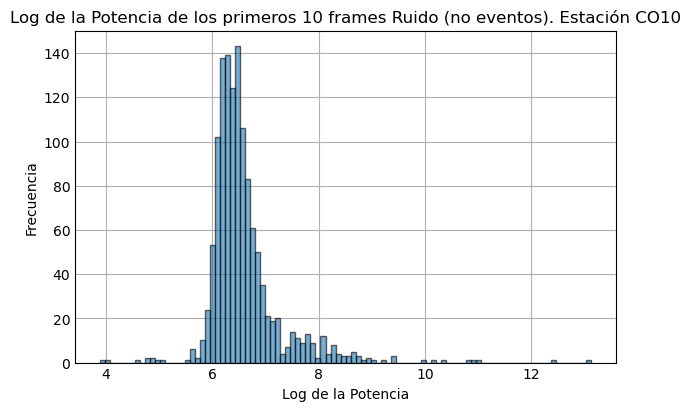

In [33]:
plot_power_each(power_events_no_event, st ,n_frames = 10, use_log = True, event_type=event_type[2])

## 4.3. Comparación a través del histograma de 3 casos diferentes

### Histograma de la potencia en escala log para una cantidad dada de frames

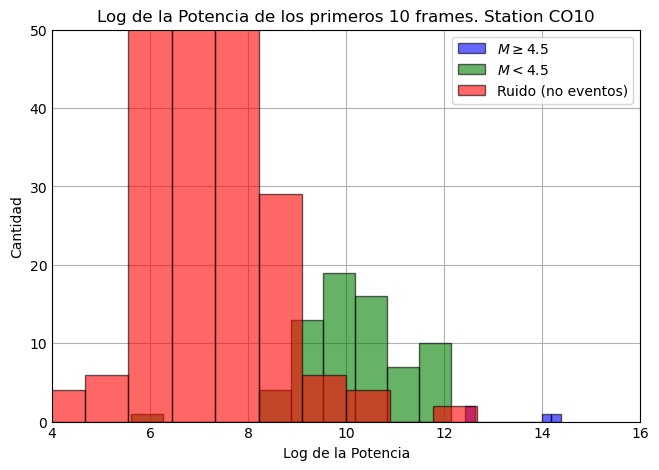

In [34]:
plot_power(power_events_all, station = st,n_frames=10, use_log=True, event_type=event_type)


### Histograma de la energía en escala log para un frame particular dado

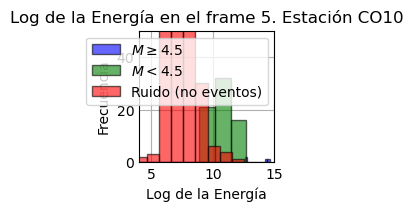

In [35]:
plot_energy_hist(energy_events_all, station = st ,frame = 5, use_log = True, event_type = event_type)

# 5. Gráfico de curvas ROC y matriz de confusión para validación según el criterio de ENERGÍA

Como para realizar esto se necesitan tener solo dos clases, del tipo "sí" y "no", no podemos llegar y usar lo que tenemos antes directamente. Esto ya que antes consideramos 3 clases distintas. Debido a esto, se considera desde ahora dos casos de separación:
1) Sismo vs No-Sismo
2) Sismo M>4 vs No-Sismo M>4 (acá entran tanto sismos menores que 4 como cosas que no son sismos)

## 5.1. Sismo vs No-Sismo

### 5.1.1. Comenzamos definiendo las clases y asignando los labels. Consideramos un sismo como 1, y un no sismo como 0

In [36]:
classes = ['No Event', 'Event']

energy_events_flattened = [np.concatenate(events) for events in energy_events_all]
data = np.concatenate(energy_events_flattened)
# Como estamos trabajando con el log de 10 antes, lo hacemos tambien acá, hace todo más bonito jjjjjeee
log_data = np.log10(data)

labels = np.concatenate([np.ones(len(energy_events_flattened[0])),
                         np.ones(len(energy_events_flattened[1])),
                         np.zeros(len(energy_events_flattened[2]))])


### 5.1.2. Se realiza el cálculo y plot de la curva ROC y el AUC usando sklearn.

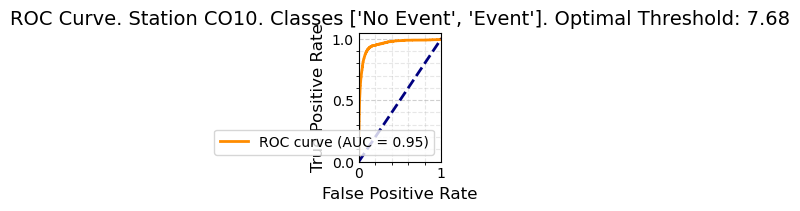

In [37]:
plot_roc_curve(labels, st ,log_data, classes)

### 5.1.3. Usado calculate_optimal_threshold de metrics.py podemos calcular el umbral óptimo según diferentes métodos

In [38]:
# LOs 3 metodos que tengo implementdo son: 'youden_index', 'euclidena_distance', 'concordance_probability'. POr defecto la función usa 'youden_index'
optimal_thr = calculate_optimal_threshold(labels, log_data)

### 5.1.4. Se plotea la matriz de confusión 

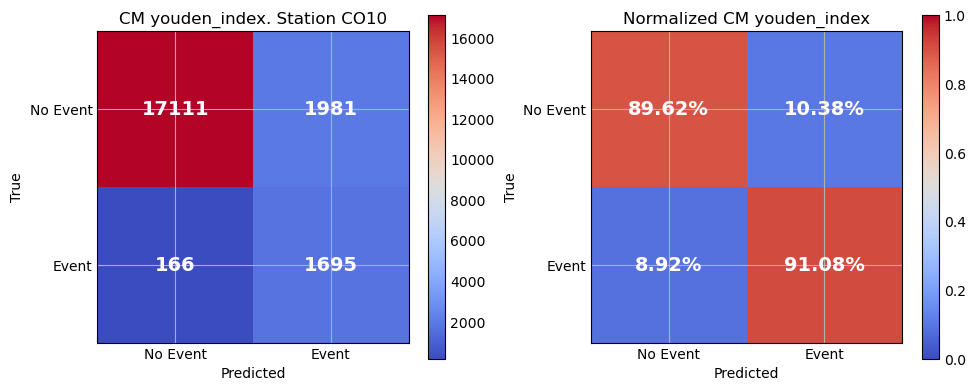

In [39]:
plot_confusion_matrix2(optimal_thr,st, 'youden_index', labels, log_data, classes)


## 5.2. Evento mayor a 4 vs No evento mayor a 4

In [40]:
classes = [f'No M>={magnitude}', f'M>={magnitude}']

#lo que cambia es la forma en que se crean los labels
labels = np.concatenate([np.ones(len(energy_events_flattened[0])),
                         np.zeros(len(energy_events_flattened[1])),
                         np.zeros(len(energy_events_flattened[2]))])


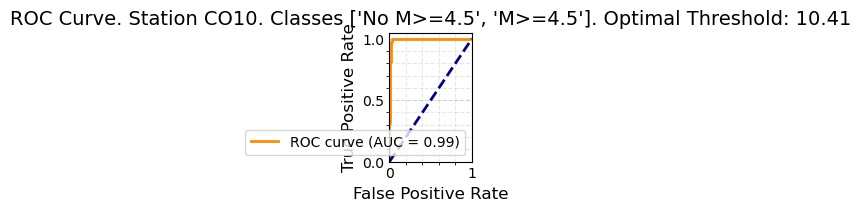

In [41]:
plot_roc_curve(labels, st ,log_data, classes)

In [42]:
optimal_thr = calculate_optimal_threshold(labels, log_data)

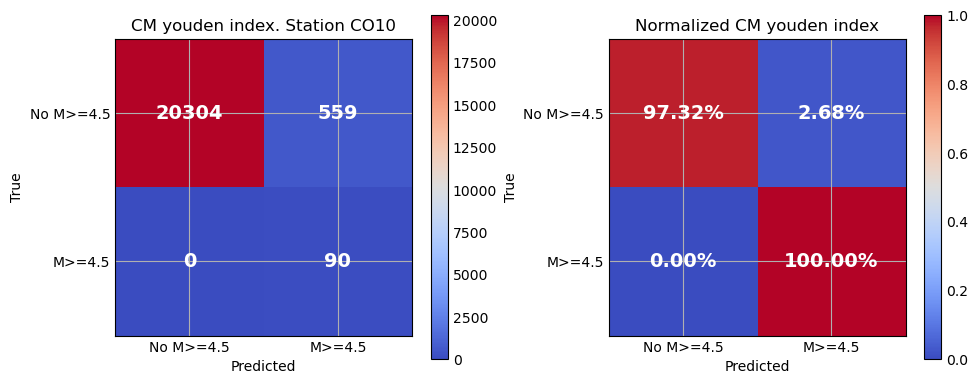

In [43]:
plot_confusion_matrix2(optimal_thr, st , 'youden index', labels, log_data, classes)

Lo anterior considera energía por la siguiente razón:
- Cada uno de los TP, FN, FP, TP que fueron calculados antes, fueron calculados para cada frame correspondiente a la clase respectiva a la que se econtrase.
- Así, si tengo un 100% de eventos bien clasificados, significa que todos los frames que de todos los eventos superan el umbral para poder ser clasificados como eventos.
- Por otro lado, el tener menos del 100% de clasificación en los TP, no implica que no detectara el evento per se, solo implica que no todos los frames del evento superan el umbral mínimo para que ese frame fuese considerado como perteneciente a un evento.

# 6. Ahora usando como criterio de separación la potencia

Se considerará la potencia hasta que se acaba el evento, no un número de frames especifico ni modificable por el momento.

## 6.1. Sismo vs No sismo

In [91]:
classes = ['No Event', 'Event']

# La siguiente linea de código toma la potencia en el último frame para cada evento (o no evento)
power_last_frame = [arr[-1] for tup in power_events_all for arr in tup]
data_power = np.array(power_last_frame)
# Como estamos trabajando con el log de 10 antes, lo hacemos tambien acá, hace todo más bonito jjjjjeee
log_data_power = np.log10(data_power)

labels_power = np.concatenate([np.ones(len(power_events_all[0])),
                         np.ones(len(power_events_all[1])),
                         np.zeros(len(power_events_all[2]))])

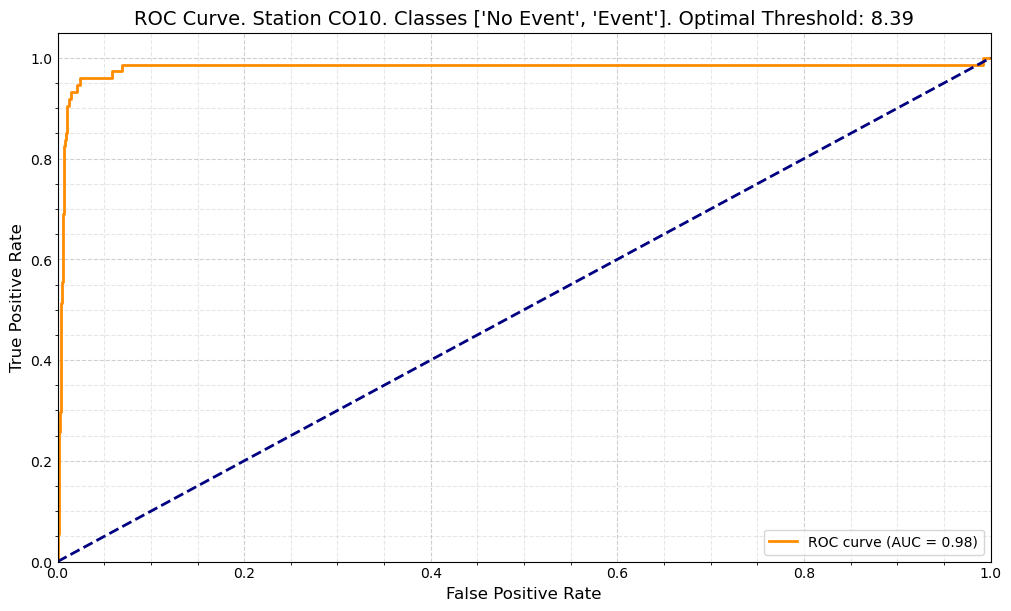

In [92]:
plot_roc_curve(labels_power, st ,log_data_power, classes, method)


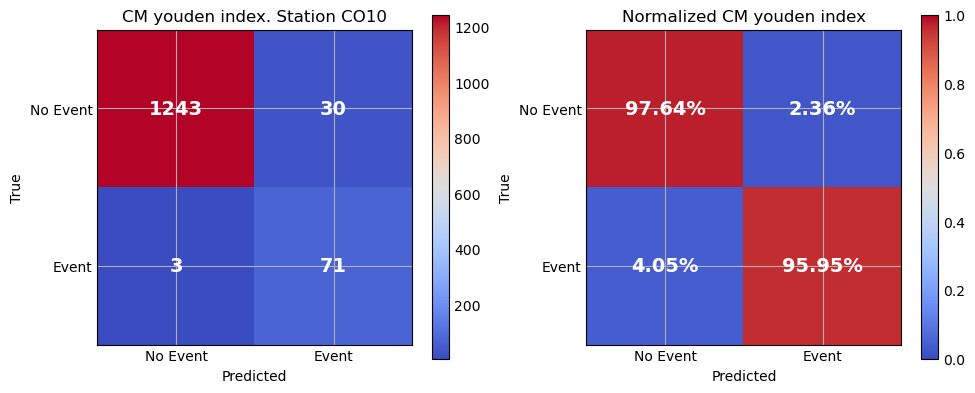

In [93]:
optimal_thr_power = calculate_optimal_threshold(labels_power, log_data_power)
plot_confusion_matrix2(optimal_thr_power, st , 'youden index', labels_power, log_data_power, classes)

## 6.2. Sismos M>=magnitude Vs Resto

In [105]:
classes = [f'No M>={magnitude}', f'M>={magnitude}']

labels_power = np.concatenate([np.ones(len(power_events_all[0])),
                                np.zeros(len(power_events_all[1])),
                                np.zeros(len(power_events_all[2]))])


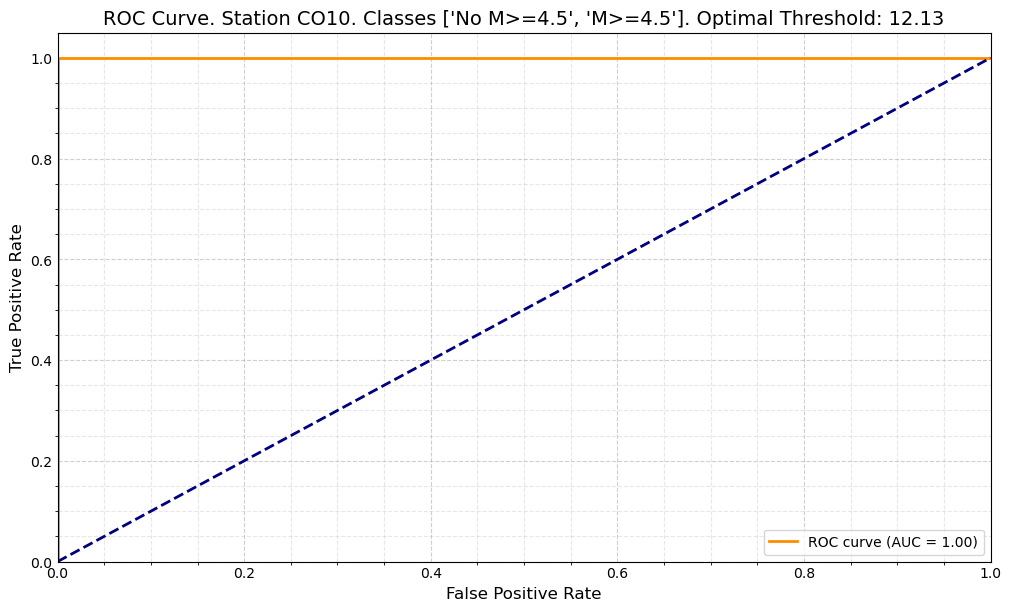

In [96]:
method = 'euclidean_distance'
plot_roc_curve(labels_power, st, log_data_power, classes, method = method)

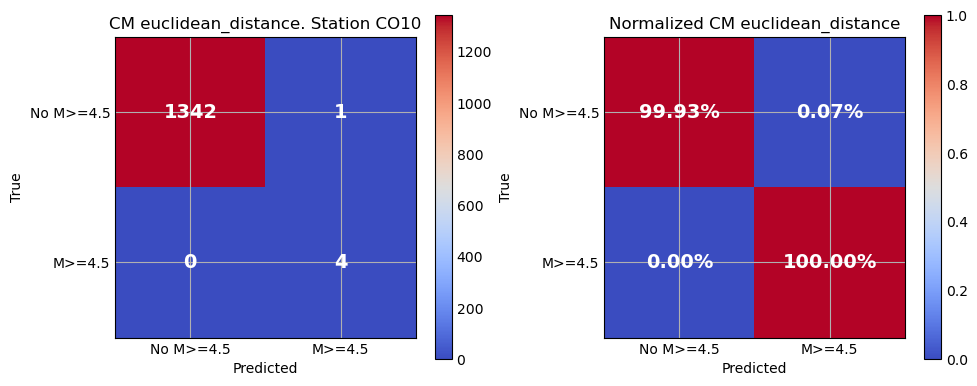

In [97]:

optimal_thr_power = calculate_optimal_threshold(labels_power, log_data_power, method=method)
plot_confusion_matrix2(optimal_thr_power, st ,method , labels_power, log_data_power, classes)

## 6.3 Encontrar la menor magnitud para la cual se separan los eventos 

In [108]:
# Ejemplo de uso
magnitudes_a_probar = np.linspace(3.0,5.0,21)
best_magnitude, best_distance, labels, data= find_best_magnitude(file_over = file_over, file_under = file_under, stations_coord = stations_coord ,
                                               stations_names = stations_names, stations_dic = stations_dic, magnitudes = magnitudes_a_probar)

print(f"La magnitud que separa perfectamente a los eventos es {best_magnitude} con una distancia a la esquina superior izquierda de {best_distance:.2f}")


La mejor magnitud es 4.7 con una distancia a la esquina superior izquierda de 0.00


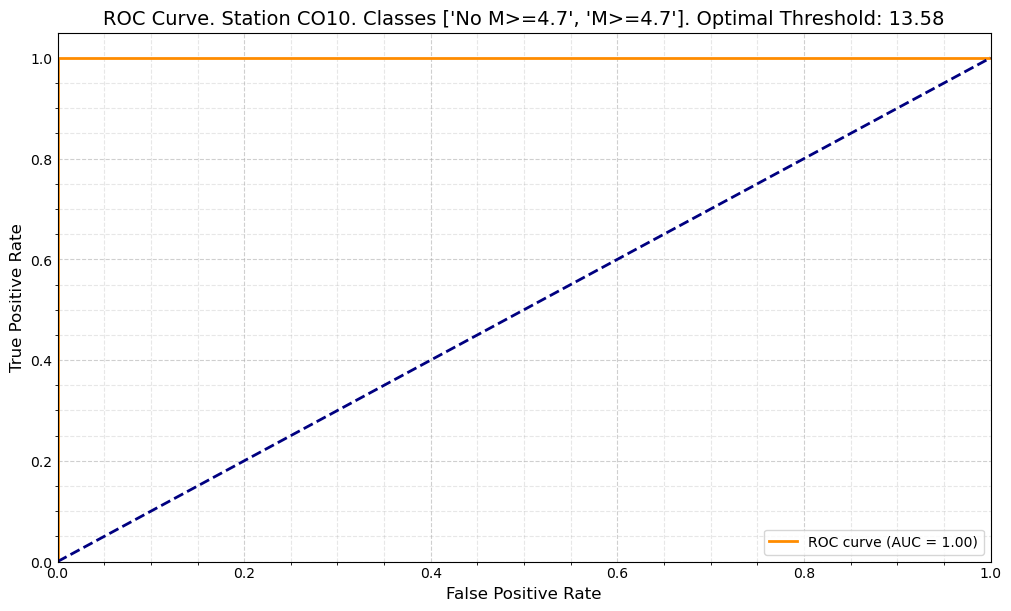

In [110]:
classes_best = [f'No M>={best_magnitude}', f'M>={best_magnitude}']

plot_roc_curve(labels, st, data, classes_best, method)

# Idea para seguir 

Cada una de las secciones que hice anteriormente recodearlas comno funciones, esto haría que todo fuese mucho más simple en términos de la facilidad de la magnitud de los eventos que quiero tomar, etc. Hacerlo despúes de almuerzo